# Predicting a Wine’s Cultivator from its Chemical Characteristics

This dataset is a result of chemical analysis done on different wines grown in the same Italien region, but originating from 3 different cultivators. Each row contains the quantity of 13 different chemical constituents found in a wine from a particular cultivator. This model will attempt to use these measurements to predict a wine’s cultivator, answering the question: “based on the chemical composition of a wine, can its origin be determined?”

Please note no units were provided in the dataset or website.

In [16]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(httr)
library(GGally)

In [17]:
set.seed(9999)

# read data
wine_path <- 'https://raw.githubusercontent.com/JadenMajid/dsci-100-student-grades/main/wine.data'

wine_data <- read_delim(file = wine_path, delim = ",", col_names = FALSE) |>
    mutate(X1 = as_factor(X1)) |>
    select(-X14)

# column names obtained from UCI Ml website
colnames(wine_data) <- c('alcohol', 'malic_acid', 'ash', 'alcalinity', 'magnesium', 'total_phenols',
                         'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity',
                         'hue', 'ODnum', 'proline')
# split data
split <- wine_data |>
    initial_split(prop = 0.75, strata = alcohol)

wine_training_data <- training(split)
wine_test_data <- testing(split)

Rows: 178 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Preliminary Exploratory Data Analysis

In [3]:
# mean
mean_stats <- wine_training_data |>
    group_by(alcohol) |>
    summarize(across(malic_acid:proline, mean))
mean_stats

alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,ODnum,proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,13.75932,1.859318,2.455227,16.84318,105.75000,2.852500,2.9877273,0.2840909,1.915227,5.478636,1.0700000,3.186136
2,12.26792,2.030377,2.226038,20.03774,95.60377,2.280943,2.0996226,0.3547170,1.633208,3.086981,1.0452075,2.809811
3,13.12861,3.369444,2.439167,21.40278,99.72222,1.615556,0.7622222,0.4369444,1.062778,6.859722,0.6972222,1.699722


In [4]:
# max
max_stats <- wine_training_data |>
    group_by(alcohol) |>
    summarize(across(malic_acid:proline, max))
max_stats

alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,ODnum,proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14.83,3.59,2.87,22.5,127,3.85,3.93,0.43,2.96,8.7,1.28,4.00
2,13.67,5.80,3.23,30.0,162,3.52,5.08,0.66,3.58,6.0,1.71,3.69
3,14.16,5.51,2.75,27.0,123,2.32,1.57,0.63,1.56,10.8,0.96,2.47


In [5]:
# minimum
min_stats <- wine_training_data |>
    group_by(alcohol) |>
    summarize(across(malic_acid:proline, min))
min_stats

alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,ODnum,proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,12.85,1.35,2.10,11.2,91,2.35,2.19,0.17,1.25,3.52,0.86,2.51
2,11.03,0.89,1.36,10.6,70,1.10,0.57,0.13,0.41,1.28,0.69,1.59
3,12.20,1.24,2.15,17.5,80,0.98,0.34,0.21,0.55,3.85,0.48,1.27


In [6]:
# number of wines from each region
counts <- wine_training_data |>
    group_by(alcohol) |>
    summarize(count = n())
counts

alcohol,count
<fct>,<int>
1,44
2,53
3,36


### Exploratory Visualization

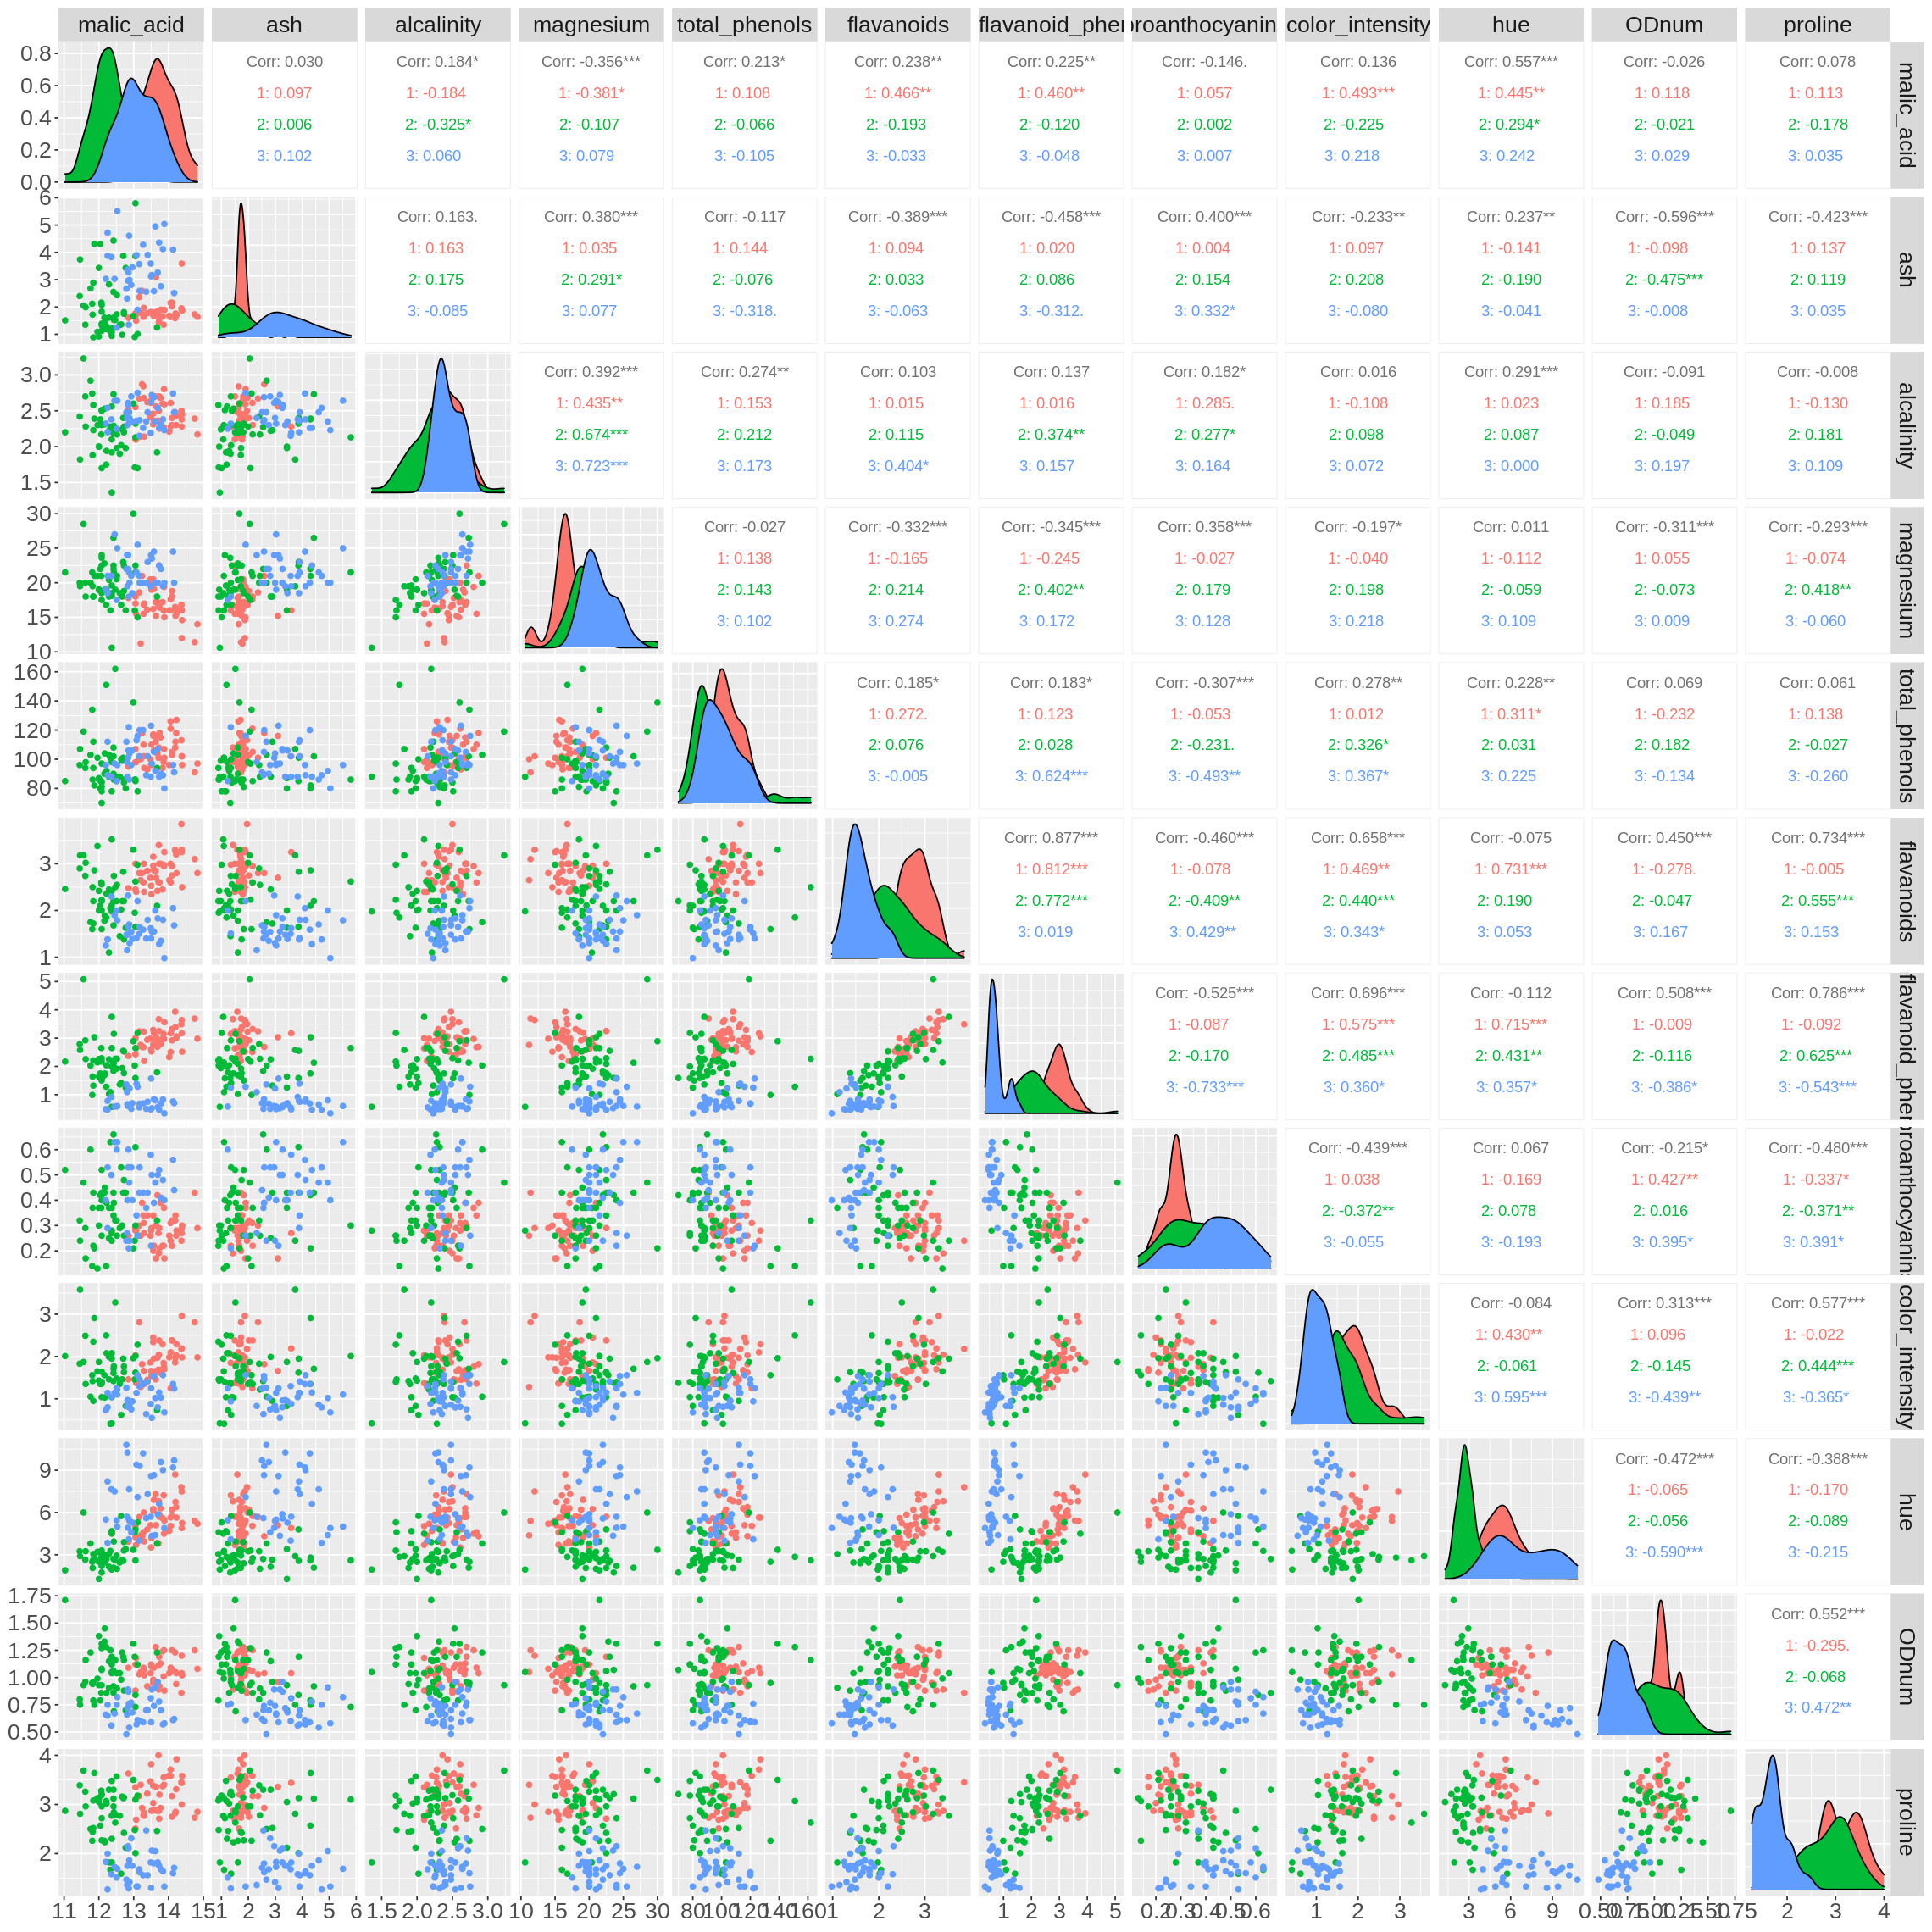

In [7]:
# scatter plots of the variables
options(repr.plot.width = 19, repr.plot.height = 19)
wine_training_data |> 
  ggpairs(columns = 2:13, ggplot2::aes(colour = alcohol))+
    theme(text = element_text(size = 20))#, upper = list(continuous = "density", combo = "box_no_facet")

### Methods
A classification model will be used, since the cultivator can only be one of three things. Though there are numerous variables, only two will be chosen, as not all are useful for prediction. 

By looking at the visualization, pairs of variables can be identified as strong candidates for analysis. Examples are the plots of “Malic acid versus Proline” and “Non Flavonoid Phenols versus Hue”. Wines from each region are separated into relatively clear areas in the plot. 

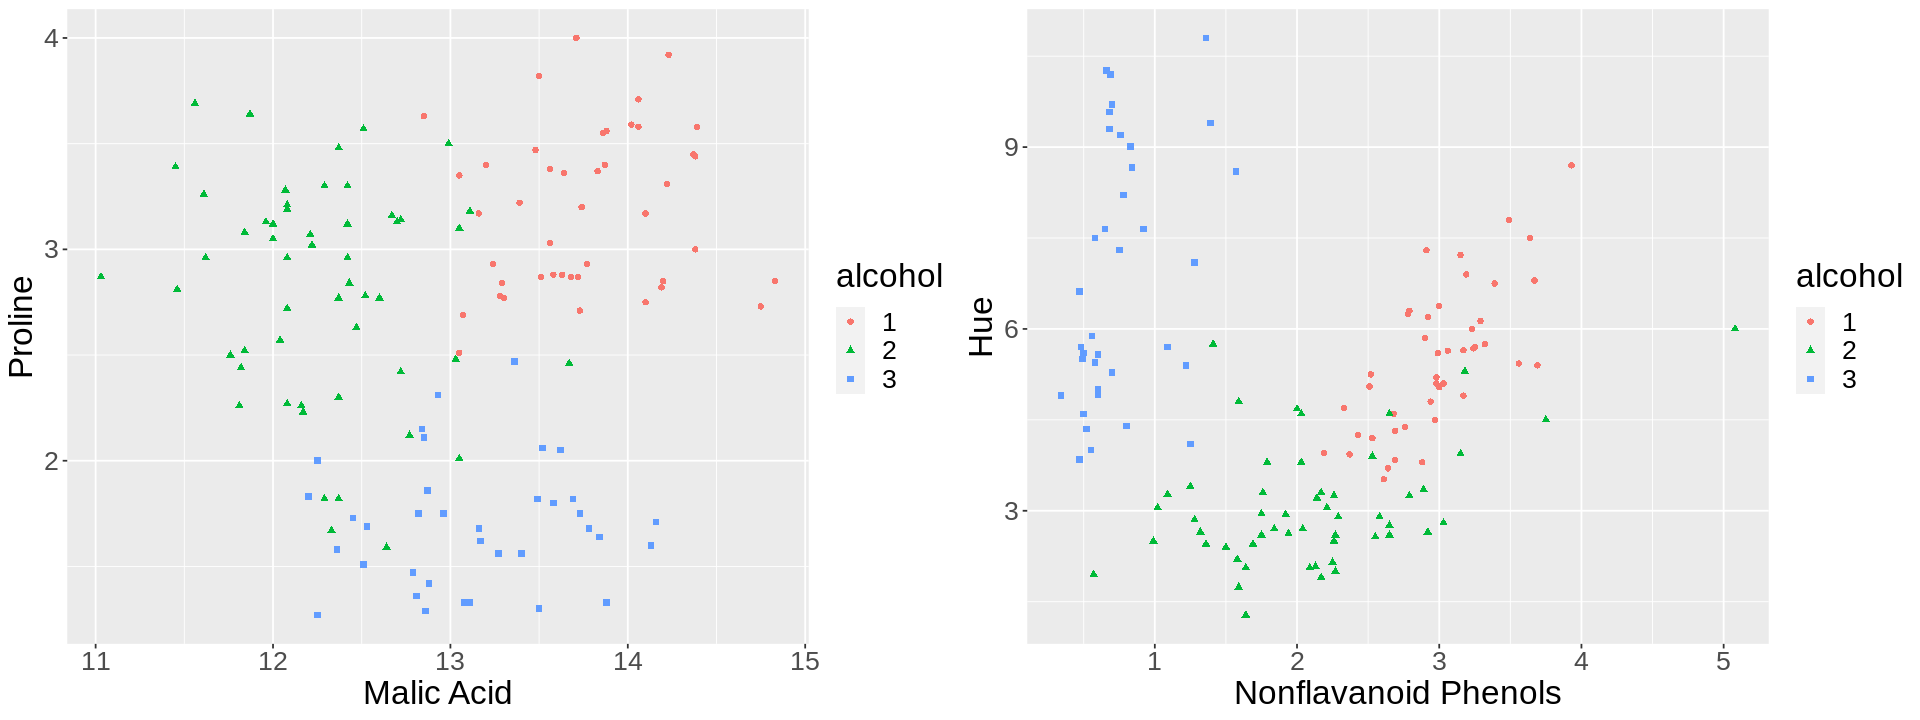

In [52]:
options(repr.plot.width = 16, repr.plot.height = 6)
malic_acid_proline_plot <- wine_training_data |>
    ggplot(aes(x = malic_acid, y = proline, color = alcohol, shape = alcohol)) +
    geom_point() +
    labs(x = "Malic Acid", y = "Proline") + 
    theme(text = element_text(size = 20))


nonflavanoid_hue_plot <- wine_training_data |>
    ggplot(aes(x = nonflavanoid_phenols, y = hue, color = alcohol, shape = alcohol)) +
    geom_point() +
    labs(x = "Nonflavanoid Phenols", y = "Hue") + 
    theme(text = element_text(size = 20))


plot_of_options <- plot_grid(malic_acid_proline_plot, nonflavanoid_hue_plot, ncol = 2)
plot_of_options

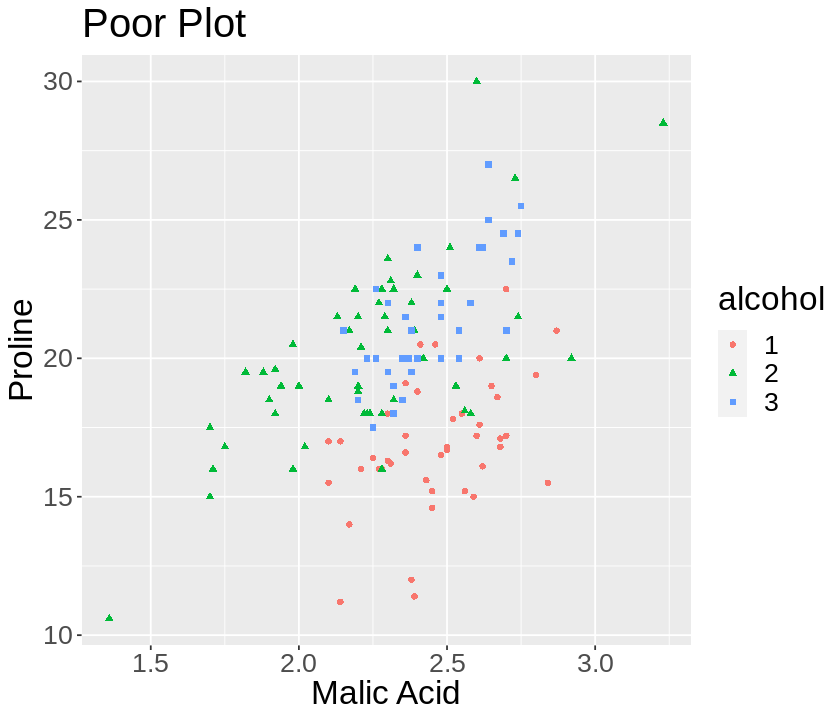

In [50]:
options(repr.plot.width = 7, repr.plot.height = 6)
alcalinity_magnesium_plot <- wine_training_data |>
    ggplot(aes(x = alcalinity, y = magnesium, color = alcohol, shape = alcohol)) +
    geom_point() +
    labs(x = "Malic Acid", y = "Proline", title = "Poor Plot") + 
    theme(text = element_text(size = 20))
alcalinity_magnesium_plot

While scaling and centering have not been performed yet, this provides a starting point. The choice is subjective, and others may make different choices. Nonetheless, the model will use the following to predict alcohol origin: Hue and Non Flavonoid Phenols. A more rigorous method of choosing the variables may be explored in a future project. 

# Model


In [60]:
set.seed(9999)

# cross validation for best neighbours to use
wine_training_data_selected <- wine_training_data |>
    select(alcohol, nonflavanoid_phenols, hue)

wine_vfold <- vfold_cv(wine_training_data_selected, v = 5, strata = alcohol)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('classification')

wine_recipe <- recipe(alcohol ~ ., data = wine_training_data_selected)  |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

grid_vals <- tibble(neighbors = seq( from = 1, to = 30))

num_results <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = wine_vfold, grid = grid_vals) |>
    collect_metrics()
#num_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9172926,5,0.007243292,Preprocessor1_Model01
2,accuracy,multiclass,0.9172926,5,0.007243292,Preprocessor1_Model02
3,accuracy,multiclass,0.8956630,5,0.026860364,Preprocessor1_Model03
4,accuracy,multiclass,0.8956630,5,0.026860364,Preprocessor1_Model04
5,accuracy,multiclass,0.9030704,5,0.024780745,Preprocessor1_Model05
6,accuracy,multiclass,0.9030704,5,0.024780745,Preprocessor1_Model06
7,accuracy,multiclass,0.9176207,5,0.027056816,Preprocessor1_Model07
8,accuracy,multiclass,0.9176207,5,0.027056816,Preprocessor1_Model08
9,accuracy,multiclass,0.9104982,5,0.036076520,Preprocessor1_Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
13,accuracy,multiclass,0.925313,5,0.02849962,Preprocessor1_Model13
14,accuracy,multiclass,0.925313,5,0.02849962,Preprocessor1_Model14


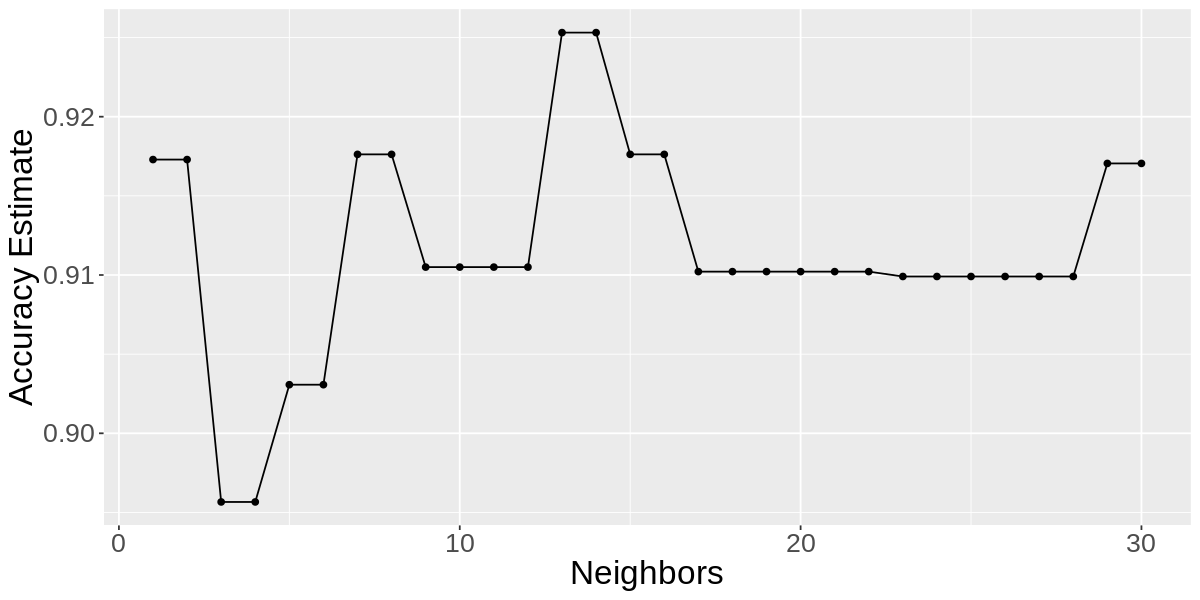

In [61]:
accuracies <- num_results |>
    filter(.metric == "accuracy")
accuracies

options(repr.plot.width = 10, repr.plot.height = 5)
cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))
cross_val_plot

best_k <- accuracies |>
    filter(mean == max(mean))
best_k


In [62]:
set.seed(9999) 
# making model with best neighbors
best_neighbors <- 13

wine_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = best_neighbors) |>
    set_engine('kknn') |>
    set_mode('classification')

wine_fit <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(wine_spec) |>
    fit(data = wine_training_data_selected)
wine_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(13,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.08270677
Best kernel: rectangular
Best k: 13

In [63]:
set.seed(9999) 
# testing model on test data
wine_predictions <- predict(wine_fit, wine_test_data) |>
    bind_cols(wine_test_data)
wine_predictions 

wine_metrics <- wine_predictions |>
    metrics(truth = alcohol, estimate = .pred_class)
wine_metrics

wine_conf_mat <- wine_predictions |>
    conf_mat(truth = alcohol, estimate = .pred_class)
wine_conf_mat

.pred_class,alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,ODnum,proline
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,14.12,1.48,2.32,16.8,95,2.20,2.43,0.26,1.57,5.000000,1.17,2.82
1,1,13.75,1.73,2.41,16.0,89,2.60,2.76,0.29,1.81,5.600000,1.15,2.90
1,1,14.30,1.92,2.72,20.0,120,2.80,3.14,0.33,1.97,6.200000,1.07,2.65
1,1,13.83,1.57,2.62,20.0,115,2.95,3.40,0.40,1.72,6.600000,1.13,2.57
1,1,12.93,3.80,2.65,18.6,102,2.41,2.41,0.25,1.98,4.500000,1.03,3.52
1,1,13.05,2.05,3.22,25.0,124,2.63,2.68,0.47,1.92,3.580000,1.13,3.20
1,1,13.76,1.53,2.70,19.5,132,2.95,2.74,0.50,1.35,5.400000,1.25,3.00
1,1,14.22,3.99,2.51,13.2,128,3.00,3.04,0.20,2.08,5.100000,0.89,3.53
1,1,13.41,3.84,2.12,18.8,90,2.45,2.68,0.27,1.48,4.280000,0.91,3.00


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9777778
kap,multiclass,0.9662921


          Truth
Prediction  1  2  3
         1 15  1  0
         2  0 17  0
         3  0  0 12

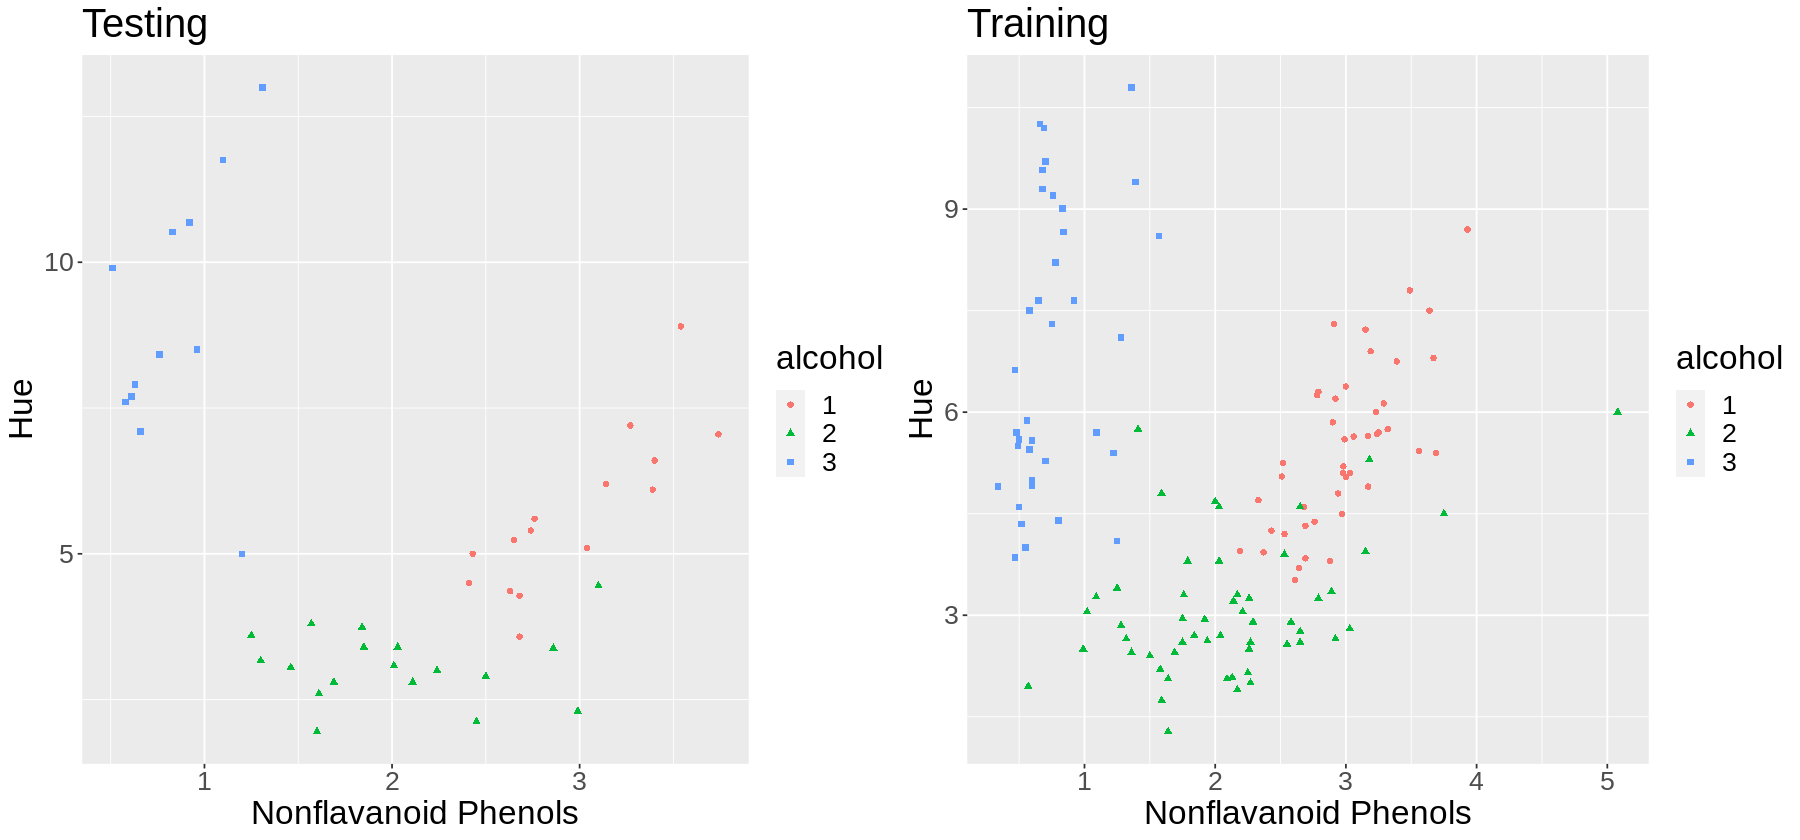

In [64]:
options(repr.plot.width = 15, repr.plot.height = 7)
nonflavanoid_hue_test_plot <- wine_test_data |>
    ggplot(aes(x = nonflavanoid_phenols, y = hue, color = alcohol, shape = alcohol)) +
    geom_point() +
    labs(x = "Nonflavanoid Phenols", y = "Hue", title = "Testing") + 
    theme(text = element_text(size = 20))
nonflavanoid_hue_plot_2 <- nonflavanoid_hue_plot + labs(title = "Training")
plot_of_options <- plot_grid(nonflavanoid_hue_test_plot, nonflavanoid_hue_plot_2, ncol = 2)
plot_of_options